# Carolina madtom

## General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()

### Config file
Some of the scripts below pull common variables from a config file.  This is so in order to reduce redundancy and also facilitates running scripts outside of jupyter notebooks.  However, variables need to be able to be set in notebooks too, so the cell below deletes and then rewrites the config file according to what to you want for this notebook.

In [2]:
# Set variables in the following text string, not variable assignment below.
text = """#NOTE! this is overwritten by some notebooks, so update everywhere, if adding lines.
sp_id = 'fcamax0'
summary_name = 'madtom'
gbif_req_id = 'GBIFr8'
gbif_filter_id = 'GBIFf2'
ebird_req_id = None
ebird_filter_id = None
evaluation = 'eval_gbif1'
workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 200
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + sp_id + gbif_req_id + gbif_filter_id + '.sqlite'
"""
f = open('config.py', 'w')
f.write(text)
f.close()

import config
species_id = config.sp_id
summary_name = config.summary_name
request_id = config.gbif_req_id
filter_id = config.gbif_filter_id
inDir = config.inDir
outDir = config.outDir
common_name = 'Carolina Madtom'

In [3]:
connjup = sqlite3.connect(config.codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

## Species Concept

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '',
 'common_name': 'carolina madtom',
 'detection_distance_meters': 0,
 'end_year': None,
 'error_tolerance': 20,
 'fws_id': 'Noturus furiosus',
 'gap_id': None,
 'gbif_id': '2341034',
 'geometry': None,
 'itis_tsn': '164015',
 'migratory': '0',
 'notes': None,
 'pad': 1,
 'scientific_name': 'Noturus furiosus',
 'species_id': 'fcamax0',
 'start_year': 1889,
 'wintering_months': ''}


## Filters

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                  GBIFr8
source                                        GBIF
lat_range                                    27,41
lon_range                                  -91,-75
years_range                             1920, 2020
months_range                                  1,12
geoissue                                      None
coordinate                                    True
continent                                     None
creator                                    N. Tarr
notes           Developed for neuse river waterdog
Name: 0, dtype: object


In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                    GBIFf2
source                                                         GBIF
has_coordinate_uncertainty                                        0
creator                                                     N. Tarr
notes                         Used for development. SAME as GBIF_f2
Name: 0, dtype: object


## Run Query

In [7]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

No GAP range was retrieved.
108 records exist


## Results

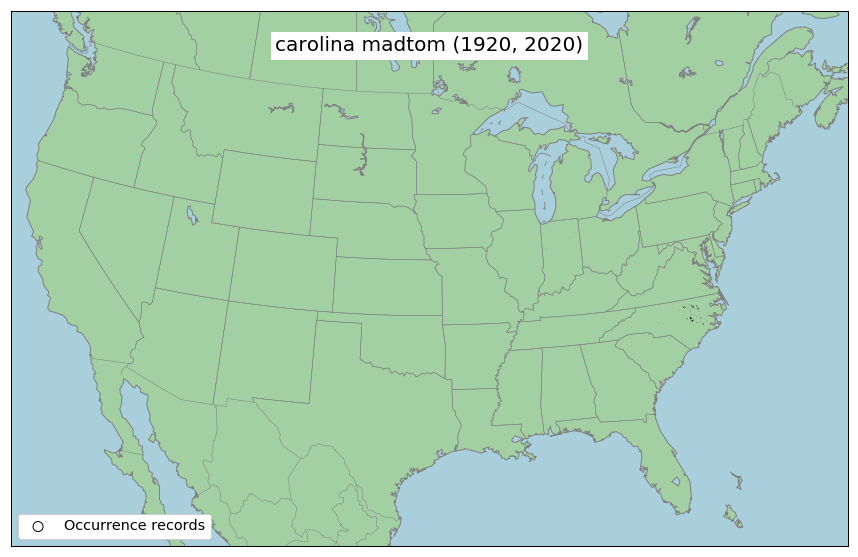

In [8]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
if os.path.isfile(gap_range2 + ".shp"):
    map_these=[shp1, shp2]
else:
    map_these=[shp2]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Where were records retrieved from?

In [9]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [request_id, filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### How many records made it through the filters?

In [10]:
conn_occ= sqlite3.connect(config.spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records made it through the filters")

108 records made it through the filters


### What years were represented in the data?

Text(0.5, 1.0, 'Occurrences per Year')

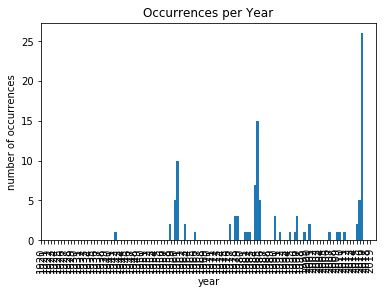

In [11]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(config.gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### What months were represented in the data?

Text(0.5, 1.0, 'Occurrences per Month')

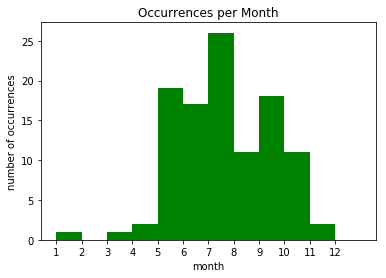

In [12]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### What is the distribution of coordinate uncertainty values?

Text(0.5, 1.0, 'Coordinate Uncertainty')

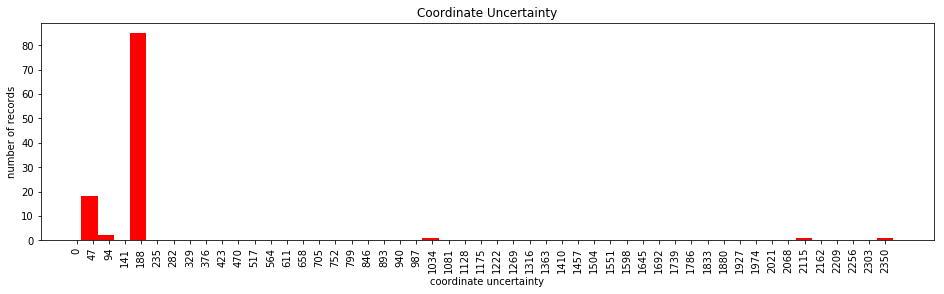

In [13]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

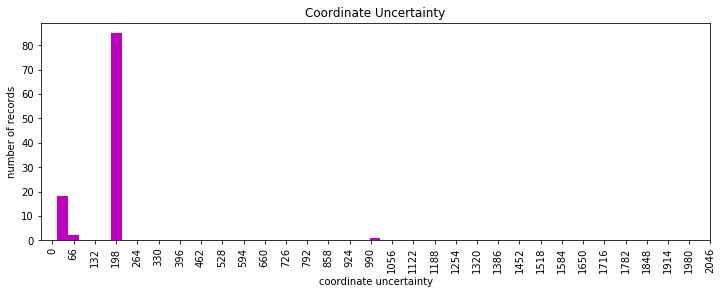

In [14]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### What geodetic datums were present in the data?

In [15]:
datums = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'datums';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### What issues were present in the data?

In [16]:
issues = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'issues';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

COORDINATE_ROUNDED
COORDINATE_REPROJECTED
MULTIMEDIA_URI_INVALID
GEODETIC_DATUM_ASSUMED_WGS84


### What were the bases of the records?

In [17]:
bases = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'bases';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

PRESERVED_SPECIMEN


### What institutions provided the records?

In [18]:
institutions = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'institutions';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

http://grbio.org/cool/8eci-0a0e
UMMZ
Ohio State University - Fish Division
Columbus
OH (OSUM)
NCSM
UF


### What data collections were included?

In [19]:
collections = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'collections';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

NCSM-Fishes
Fish
Fishes
ummz_fish
UAIC


### Were there duplicate records?

In [20]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

6 records were duplicates based on xy coordinate and date-time


### What keys/fields were returned for the records?

In [21]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                                included(n)  populated(n)
field                                                    
acceptedScientificName                  108           108
acceptedTaxonKey                        108           108
accessRights                            100           100
basisOfRecord                           108           108
bibliographicCitation                   100           100
catalogNumber                           108           108
class                                   108           108
classKey                                108           108
collectionCode                          108           108
continent                               104           104
coordinateUncertaintyInMeters            24            24
country                                 108           108
countryCode                             108           108
county                                  108           108
crawlId                                 108           108
datasetID     

### Runtime

In [22]:
t2 = datetime.now()
print(t2 - t1)

0:00:50.820213
